In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Data import
genres = ["classical", "electronic", "pop", "rock"]

ZC = np.load('../preprocessing/zeroCrossings_frame200ms_hop100ms.npy')
SC = np.load('../preprocessing/spectralCentroid_frame200ms_hop100ms.npy')
SV = np.load('../preprocessing/spectralVariance_frame200ms_hop100ms.npy')

In [3]:
print("Shape ZC", np.shape(ZC))
print("Shape SC", np.shape(SC))
print("Shape SV", np.shape(SV))

Shape ZC (400, 598)
Shape SC (400, 598)
Shape SV (400, 598)


In [4]:
ZC = (ZC - np.nanmean(ZC)) / np.nanstd(ZC)
SC = (SC - np.nanmean(SC)) / np.nanstd(SC)
SV = (SV - np.nanmean(SV)) / np.nanstd(SV)


features = np.stack((ZC, SC, SV), axis=1)
print(np.shape(features))

(400, 3, 598)


In [5]:
label_songs = pd.read_csv("../preprocessing/labels.csv")
info_songs = pd.read_csv("../Info/info.csv")

select_label = "genre"

if select_label == "genre":
    labels = label_songs[select_label].map({"classical":0, "electronic":1, "pop":2, "rock":3})
labels = labels.to_numpy()

In [6]:
n_data = len(label_songs)
idx = np.random.permutation(n_data)
info_songs = info_songs.reindex(idx)
features = features[idx, :, :]
labels = labels[idx]

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

sample_size = (3, 50, 1)

drop_out_rate = 0.4

input_tensor = Input(sample_size)
#x = layers.Conv2D(8, (1, 10), padding="valid", activation="relu", strides=1)(input_tensor)

x = layers.Conv2D(8, (1, 10), padding="valid", activation="relu", strides=1)(input_tensor)

#x = layers.Conv2D(16, (1, 10), padding="valid", activation="relu", strides=1)(x)
#x = layers.MaxPooling2D(pool_size=(4,1))(x)
#x = layers.Dropout(drop_out_rate)(x)
#x = layers.Dense(10, activation="relu")(x)

#x = layers.Dense(5, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(4, activation="softmax")(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 50, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 41, 8)          88        
_________________________________________________________________
flatten (Flatten)            (None, 984)               0         
_________________________________________________________________
dropout (Dropout)            (None, 984)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3940      
Total params: 4,028
Trainable params: 4,028
Non-trainable params: 0
_________________________________________________________________


In [8]:
def slice_accordingly(input_tensor, labels, size=50):

    input_shape = (tf.shape(input_tensor).numpy())
    
    input_shape[2] = size
    size = input_shape
    
    sliced_tensor = tf.image.random_crop(input_tensor, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

In [9]:
fraction_validation = 0.25
n_test = int(fraction_validation*len(labels))
n_train = len(labels) - n_test

train_features, train_labels = features[:n_train], labels[:n_train]
validation_features, validation_labels = features[n_train:], labels[n_train:]

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))

In [10]:
import matplotlib.pyplot as plt

model = model_1

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

n_epochs = 50
batch_size = 50

plot_weights = True

weights_dict = {}

for epoch in range(n_epochs):
    print("Epoch", epoch)
    train_ds = train_dataset.shuffle(n_train).batch(batch_size)
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    for X, Y in train_ds:
        X, Y = slice_accordingly(X, Y)
        
        history = model.fit(X, Y,
                           validation_data=(x_val, y_val),
                           verbose=1) 
        
    if plot_weights:
        
        weights_convlayer1 = model.layers[1].weights
        bias_convlayer1 = weights_convlayer1[1].numpy()
        weights_convlayer1 = weights_convlayer1[0].numpy()

        shape_weights = np.shape(weights_convlayer1)
        weights_convlayer1 = np.reshape(weights_convlayer1, (shape_weights[1], shape_weights[3]))

        weights_dict[epoch] = np.transpose(weights_convlayer1)
        #plt.imshow(np.transpose(weights_convlayer1))
        
        #plt.savefig(f"FiguresWeights/Weights_epoch_{epoch}.png")

Epoch 0
2/2 [==============================] - 0s 83ms/step - loss: 1.2376 - accuracy: 0.3800 - val_loss: 1.2526 - val_accuracy: 0.4000
Epoch 1
2/2 [==============================] - 0s 77ms/step - loss: 1.2134 - accuracy: 0.4200 - val_loss: 1.2498 - val_accuracy: 0.4400
Epoch 2
2/2 [==============================] - 0s 84ms/step - loss: 1.0686 - accuracy: 0.5200 - val_loss: 1.3915 - val_accuracy: 0.3900
Epoch 3
2/2 [==============================] - 0s 81ms/step - loss: 1.1245 - accuracy: 0.5000 - val_loss: 1.3215 - val_accuracy: 0.3400
Epoch 4
2/2 [==============================] - 0s 84ms/step - loss: 1.3386 - accuracy: 0.3000 - val_loss: 1.2588 - val_accuracy: 0.4000
Epoch 5
2/2 [==============================] - 0s 79ms/step - loss: 1.3597 - accuracy: 0.2800 - val_loss: 1.2561 - val_accuracy: 0.3600
Epoch 6
2/2 [==============================] - 0s 80ms/step - loss: 1.1431 - accuracy: 0.5200 - val_loss: 1.3112 - val_accuracy: 0.3800
Epoch 7
2/2 [==============================] - 0

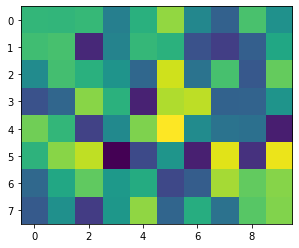

In [11]:
weights_convlayer1 = model.layers[1].weights
bias_convlayer1 = weights_convlayer1[1].numpy()
weights_convlayer1 = weights_convlayer1[0].numpy()

shape_weights = np.shape(weights_convlayer1)
weights_convlayer1 = np.reshape(weights_convlayer1, (shape_weights[1], shape_weights[3]))

import matplotlib.pyplot as plt
plt.imshow(np.transpose(weights_convlayer1))

In [16]:
%matplotlib notebook

import IPython

import matplotlib.animation
from IPython.display import HTML

#im = plt.imshow(weights_dict[0])

fig = plt.figure( figsize=(5,5) )
plt.xlabel("Weights")
plt.ylabel("Neuron")

a = weights_dict[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(weights_dict[0]), vmax=np.max(weights_dict[0]))

def init():
    im.set_data(weights_dict[0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    im.set_array(weights_dict[i])
    return [im]

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=50)

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>